# From MLOOps to MLOps

Multi-generative demo which shows a (really bad) comic book generator from voice.

This lifts most content from other notebooks:

- `whisper/whisper-example.ipynb` for the automatic speech recognition
- `natural-language-processing/FLAN-T5-generative-inference.ipynb` for the Text-to-text pipeline
- And the stable diffusion notebooks

[![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you.

To run the demo using other IPU hardware, you need to have the Poplar SDK enabled. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to enable the Poplar SDK. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

## Dependencies

IPU Whisper runs faster with the latest features available in SDK > 3.3.0.

In [1]:
import os
executable_cache_dir = "/storage/mloops-demo/executable-caches"

%env POPTORCH_CACHE_DIR=/storage/mloops-demo/executable-caches
%env POPLAR_EXECUTABLE_CACHE_DIR=/storage/mloops-demo/executable-caches
%env HUGGINGFACE_HUB_CACHE=/storage/mloops-demo/huggingface_caches
%env TRANSFORMERS_CACHE=/storage/mloops-demo/huggingface_caches/checkpoints

env: POPTORCH_CACHE_DIR=/storage/mloops-demo/executable-caches
env: POPLAR_EXECUTABLE_CACHE_DIR=/storage/mloops-demo/executable-caches
env: HUGGINGFACE_HUB_CACHE=/storage/mloops-demo/huggingface_caches
env: TRANSFORMERS_CACHE=/storage/mloops-demo/huggingface_caches/checkpoints


In [2]:
!apt update -y
!apt install -y ffmpeg

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1068 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2858 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]                
Get:5 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [28.5 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2482 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:12 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:13 http://arch

In [3]:
import poptorch
import re
import warnings

sdk_version = !popc --version
if sdk_version and (version := re.search(r'\d+\.\d+\.\d+', sdk_version[0]).group()) >= '3.3':
    print(f"SDK check passed.")
    enable_sdk_features=True
else:
    warnings.warn("SDK versions lower than 3.3 do not support all the functionality in this notebook so performance will be reduced. We recommend you relaunch the Paperspace Notebook with the Pytorch SDK 3.3 image. You can use https://hub.docker.com/r/graphcore/pytorch-early-access", 
                  category=Warning, stacklevel=2)
    enable_sdk_features=False

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3343: Warning: SDK versions lower than 3.3 do not support all the functionality in this notebook so performance will be reduced. We recommend you relaunch the Paperspace Notebook with the Pytorch SDK 3.3 image. You can use https://hub.docker.com/r/graphcore/pytorch-early-access
  exec(code_obj, self.user_global_ns, self.user_ns)


If the above cell did not pass the SDK check, you can open a runtime with our SDK 3.3.0-EA enabled by clicking the Run on Gradient button below.

[![Run on Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://ipu.dev/kC8VBy)


Install the dependencies the notebook needs.

In [4]:
# Install optimum from source 
%pip install "optimum-graphcore>=0.6, <0.7"
%pip install soundfile==0.12.1 librosa==0.10.0.post2 tokenizers==0.12.1 gradio
%pip install matplotlib fastapi
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 64.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 64.3 MB/s e

## Automatic speech recognition with Whisper

We start by importing the required modules, some of which are needed to configure the IPU.


In [5]:
# Generic imports
from datasets import load_dataset
import matplotlib.pyplot as plt
import librosa
import IPython
import random

# IPU-specific imports
from optimum.graphcore import IPUConfig
from optimum.graphcore.modeling_utils import to_pipelined
from optimum.graphcore.models.whisper import WhisperProcessorTorch

# HF-related imports
from transformers import WhisperForConditionalGeneration

The Whisper model is available on Hugging Face in several sizes, from `whisper-tiny` with 39M parameters to `whisper-large` with 1550M parameters.

We download `whisper-tiny` which we will run using two IPUs.
The [Whisper architecture](https://openai.com/research/whisper) is an encoder-decoder Transformer, with the audio split into 30-second chunks.
For simplicity one IPU is used for the encoder part of the graph and another for the decoder part.
The `IPUConfig` object helps to configure the model to be pipelined across the IPUs.

In [6]:
model_spec = "openai/whisper-tiny.en"

# Instantiate processor and model
processor = WhisperProcessorTorch.from_pretrained(model_spec)
model = WhisperForConditionalGeneration.from_pretrained(model_spec)

# Adapt whisper-tiny to run on the IPU
ipu_config = IPUConfig(ipus_per_replica=2)
pipelined_model = to_pipelined(model, ipu_config)
pipelined_model = pipelined_model.parallelize(
    for_generation=True, 
    use_cache=True, 
    batch_size=1, 
    max_length=250,
    on_device_generation_steps=16, 
    use_encoder_output_buffer=enable_sdk_features
).half()

def whisper_transcribe(data, rate):
    input_features = processor(data, return_tensors="pt", sampling_rate=rate).input_features.half()

    # This triggers a compilation, unless a precompiled model is available.
    sample_output = pipelined_model.generate(
        input_features,
        use_cache=True,
        do_sample=False,
        max_length=448, 
        min_length=3)
    transcription = processor.batch_decode(sample_output, skip_special_tokens=True)[0]
    return transcription

Now we can load the dataset and process an example audio file.
If precompiled models are not available, then the first run of the model triggers two graph compilations.
This means that our first test transcription could take a minute or two to run, but subsequent runs will be much faster.

In [7]:
# load the dataset and read an example sound file
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
test_sample = ds[2]
sample_rate = test_sample['audio']['sampling_rate']


test_transcription = whisper_transcribe(test_sample["audio"]["array"], sample_rate)
test_transcription

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_dummy downloaded and prepared to /tmp/huggingface_caches/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


Graph compilation: 100%|██████████| 100/100 [00:38<00:00]


' He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind.'

In the next cell, we compare the expected text from the dataset with the transcribed result from the model.
There will typically be some small differences, but even `whisper-tiny` does a great job! It even adds punctuation.

You can listen to the audio and compare the model result yourself using the controls below.

In [8]:
print(f"Expected: {test_sample['text']}\n")
print(f"Transcribed: {test_transcription}")


Expected: HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND

Transcribed:  He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind.


The model only needs to be compiled once. Subsequent inferences will be much faster.
In the cell below, we repeat the exercise but with a random example from the dataset.

You might like to re-run this next cell multiple times to get different comparisons.

In [9]:
idx = random.randint(0, ds.num_rows - 1)
data = ds[idx]["audio"]["array"]

print(f"Example #{idx}\n")
print(f"Expected: {ds[idx]['text']}\n")
print(f"Transcribed: {whisper_transcribe(data, sample_rate)}")

IPython.display.Audio(data, rate=sample_rate, autoplay=True)

Example #27

Expected: WHERE IS MY BROTHER NOW

Transcribed:  Where is my brother now?


# Running Flan-T5

In this demo we use a Generative text model to refine our prompts for the Stable diffusion.

In December 2022 Google published [Scaling Instruction-Finetuned Language Models](https://arxiv.org/abs/2210.11416) in which they perform extensive fine-tuning for a broad collection of tasks across a variety of models (PaLM, T5, U-PaLM). Part of this publication was the release of Flan-T5 checkpoints, "which achieve strong few-shot performance" with relatively modest parameter counts "even compared to much larger models" like the largest members of the GPT family.

The cell below uses the Flan-T5 checkpoints from the Hugging Face Hub and uses the `transformers` library.

In [10]:
num_t5_ipus=4

from optimum.graphcore import pipeline, IPUConfig

size = {4: "large", 16: "xl"}
flan_t5 = pipeline(
    "text2text-generation",
    model=f"google/flan-t5-{size[num_t5_ipus]}",
    ipu_config=IPUConfig.from_pretrained(
        f"Graphcore/t5-{size[num_t5_ipus]}-ipu", executable_cache_dir=executable_cache_dir
    ),
    max_input_length=896,
)

questions = [
    "Solve the following equation for x: x^2 - 9 = 0",
    "At what temperature does nitrogen freeze?",
    "In order to reduce symptoms of asthma such as tightness in the chest, wheezing, and difficulty breathing, what do you recommend?",
    "Which country is home to the tallest mountain in the world?"
]
for out in flan_t5(questions):
    print(out)

Graph compilation: 100%|██████████| 100/100 [02:59<00:00]


{'generated_text': '3'}
{'generated_text': '-32 °C'}
{'generated_text': 'take ibuprofen'}
{'generated_text': 'equatorial guinea'}


The examples below are taken from the `natural-language-processing/FLAN-T5-Generative-inference` notebook:

In [11]:
sentiment_analysis = (
    "Review: It gets too hot, the battery only can last 4 hours. Sentiment: Negative\n"
    "Review: Nice looking phone. Sentiment: Positive\n"
    "Review: Sometimes it freezes and you have to close all the open pages and then reopen where you were. Sentiment: Negative\n"
    "Review: Wasn't that impressed, went back to my old phone. Sentiment:"
)
advanced_ner = """Microsoft Corporation is a company that makes computer software and video games. Bill Gates and Paul Allen founded the company in 1975
[Company]: Microsoft, [Founded]: 1975, [Founders]: Bill Gates, Paul Allen

Amazon.com, Inc., known as Amazon , is an American online business and cloud computing company. It was founded on July 5, 1994 by Jeff Bezos
[Company]: Amazon, [Founded]: 1994, [Founders]: Jeff Bezos

Apple Inc. is a multinational company that makes personal computers, mobile devices, and software. Apple was started in 1976 by Steve Jobs and Steve Wozniak."""

context = 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24-10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.'
question = "Which NFL team represented the AFC at Super Bowl 50?"
contextual_q_a = f"{context} {question}"

intent_classification = """[Text]: I really need to get a gym membership, I'm exhausted.
[Intent]: get gym membership

[Text]: What do I need to make a carbonara?
[Intent]: cook carbonara

[Text]: I need all these documents sorted and filed by Monday.
[Intent]:"""

summarization="""
Document: Firstsource Solutions said new staff will be based at its Cardiff Bay site which already employs about 800 people.
The 300 new jobs include sales and customer service roles working in both inbound and outbound departments.
The company's sales vice president Kathryn Chivers said: "Firstsource Solutions is delighted to be able to continue to bring new employment to Cardiff."
Summary: Hundreds of new jobs have been announced for a Cardiff call centre.

Document: The visitors raced into a three-goal first-half lead at Hampden.
Weatherson opened the scoring with an unstoppable 15th-minute free-kick, and he made it 2-0 in the 27th minute.
Matt Flynn made it 3-0 six minutes later with a fine finish.
Queen's pulled a consolation goal back in stoppage time through John Carter.
Summary: Peter Weatherson netted a brace as Annan recorded only their second win in eight matches.

Document: Officers searched properties in the Waterfront Park and Colonsay View areas of the city on Wednesday.
Detectives said three firearms, ammunition and a five-figure sum of money were recovered.
A 26-year-old man who was arrested and charged appeared at Edinburgh Sheriff Court on Thursday.
Summary:
"""
text_classification_1 = """A return ticket is better value than a single.
topic: travel cost

You can start from the basic stitches, and go from there.
topic: learning knitting

The desk which I bought yesterday is very big.
topic: furniture size

George Washington was president of the United States from 1789 to 1797.
topic:"""
text_classification_2 = """FLAN-T5 was released in the paper Scaling Instruction-Finetuned Language Models - it is an enhanced version of T5 that has been finetuned in a mixture of tasks.
keywords: released, enhanced, finetuned

The IPU, or Intelligence Processing Unit, is a highly flexible, easy-to-use parallel processor designed from the ground up for AI workloads.
keywords: processor, AI

Paperspace is the platform for AI developers. providing the speed and scale needed to take AI models from concept to production.
keywords:"""

flan_t5_examples = questions + [sentiment_analysis, advanced_ner, contextual_q_a, summarization, intent_classification, text_classification_1, text_classification_2]

# Running stable diffusion

We also instantiate stable diffusion for doing text to image generation.

Stable diffusion is chosen to run on 8 IPUs:

In [12]:
number_of_stable_diffusion_ipus = 8

As was the case for the other models, stable diffusion is loaded onto IPUs in a few lines of code:

In [13]:
import torch
from diffusers import DPMSolverMultistepScheduler

from optimum.graphcore.diffusers import get_default_ipu_configs, INFERENCE_ENGINES_TO_MODEL_NAMES, IPUStableDiffusionPipeline


engine = "stable-diffusion-v1-5"  # maps to "runwayml/stable-diffusion-v1-5"
model_name = INFERENCE_ENGINES_TO_MODEL_NAMES[engine]
image_width = os.getenv("STABLE_DIFFUSION_TXT2IMG_DEFAULT_WIDTH", default=512)
image_height = os.getenv("STABLE_DIFFUSION_TXT2IMG_DEFAULT_HEIGHT", default=512)

unet_ipu_config, text_encoder_ipu_config, vae_ipu_config, safety_checker_ipu_config = \
get_default_ipu_configs(
    engine=engine, width=image_width, height=image_height, n_ipu=number_of_stable_diffusion_ipus, 
    executable_cache_dir=executable_cache_dir 
)
pipe = IPUStableDiffusionPipeline.from_pretrained(
    model_name,
    revision="fp16", 
    torch_dtype=torch.float16,
    requires_safety_checker=False,
    unet_ipu_config=unet_ipu_config,
    text_encoder_ipu_config=text_encoder_ipu_config,
    vae_ipu_config=vae_ipu_config,
    safety_checker_ipu_config=safety_checker_ipu_config
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The model is then compiled by running one inference loop:

In [14]:
pipe("apple", height=image_height, width=image_width, guidance_scale=7.5);

Graph compilation: 100%|██████████| 100/100 [00:39<00:00]


  0%|          | 0/50 [00:00<?, ?it/s]


Graph compilation: 100%|██████████| 100/100 [01:11<00:00]


# Assembling models in a single application

In this section we will assembling the models into a simple Fast API web site which will have several of our apps.

Fist we can check that our models are ready to run, we'll see below which models are running:

In [15]:
!gc-monitor --no-card-info

+-----------------------------------+------------------------+-----------------+
| Attached processes in partition p |          IPU           |      Board      |
+--------+----+--------+------------+----+----------+--------+--------+--------+
|  PID   |...d|  Time  |    User    | ID |  Clock   |  Temp  |  Temp  | Power  |
+--------+----+--------+------------+----+----------+--------+--------+--------+
|   65   |...3| 41m1s  |    root    | 0  | 1330MHz  |  N/A   |  N/A   |  N/A   |
|   65   |...3| 41m1s  |    root    | 1  | 1330MHz  |  N/A   |        |        |
|   65   |...3| 41m1s  |    root    | 2  | 1330MHz  |  N/A   |        |        |
|   65   |...3| 41m1s  |    root    | 3  | 1330MHz  |  N/A   |        |        |
+--------+----+--------+------------+----+----------+--------+--------+--------+
|   65   |...3| 41m1s  |    root    | 4  | 1330MHz  |  N/A   |  N/A   |  N/A   |
|   65   |...3| 41m1s  |    root    | 5  | 1330MHz  |  N/A   |        |        |
|   65   |...3| 41m1s  |    

Test the audio model:

In [16]:
idx = 58

transcription = whisper_transcribe(data, sample_rate)
print(f"Example #{idx}\n")
print(f"Expected: {ds[idx]['text']}\n")
print(f"Transcribed: {transcription}")

IPython.display.Audio(data, rate=sample_rate, autoplay=True)

Example #58

Expected: A RED HAIRED MOUNTAIN OF A MAN WITH AN APPARENTLY INEXHAUSTIBLE STORE OF ENERGY

Transcribed:  Where is my brother now?


In [17]:
# A little helper function for turning Librispeech IDs into audio samples

def sample_audio(audio_prompts):
    f, m, *l = audio_prompts
    audio_prompts = f, min(m, len(ds)), *l
    return np.concatenate([ds[idx]["audio"]["array"] for idx in range(*audio_prompts)])

Test linking audio and image models:

 A red-haired mountain of a man with an apparently inexhaustible store of energy.


  0%|          | 0/50 [00:00<?, ?it/s]

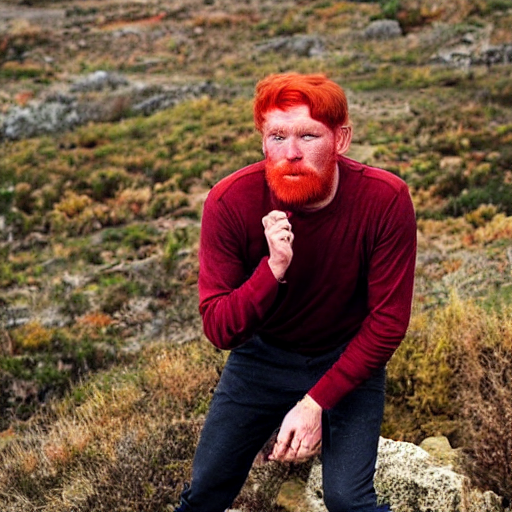

In [18]:
idx = 58
data = ds[idx]["audio"]["array"]
IPython.display.Audio(data, rate=sample_rate, autoplay=True)
transcription = whisper_transcribe(data, sample_rate)
print(transcription)
out = pipe(transcription, height=image_height, width=image_width, guidance_scale=7.5)
out.images[0]

Now the output from the ASR model does not make a good input to stable diffusion prompts.

To do that, we use FLAN-T5 to reformat our sentences, into stable diffusion prompts:

In [65]:


LLM_prompt = """
[Long text]: {previous_story}
[source] {previous_sentence} [description]:
"""

LLM_continue = """
{previous_story}
Continue the story without repetition:
"""

def LLM_to_sd_prompts(generated_text, prompt_for_sd=LLM_prompt, prompt_to_continue=LLM_continue, story_steps=3, llm_replace=False):
    print("Continuing story")
    for i in range(story_steps):
        arg = dict(
            previous_story = " ".join(generated_text),
            previous_sentence = generated_text[-1],
        )
        prompt = prompt_to_continue.format(**arg)
        out_text = flan_t5(prompt)
        generated_text.append(out_text[0]['generated_text'])
    
    print("Transformming Stable diffusion prompts")
    transformed_text = []
    if llm_replace:
        for i, sentence in enumerate(generated_text):
            arg = dict(
                previous_story = " ".join(generated_text[:i]),
                previous_sentence = generated_text[i],
            )
            prompt = prompt_for_sd.format(**arg)
            out_text = flan_t5(prompt)
            transformed_text.append(out_text[0]['generated_text'])
    else:
        transformed_text.extend(generated_text)

    return transformed_text

LLM_to_sd_prompts([transcription], LLM_prompt, LLM_continue, llm_replace=True)

Continuing story
Transformming Stable diffusion prompts


['The story is about a man who is a painter.',
 'The king has flooded disgrace, and your friends are asking for you. I begged Ruggadot long ago to send him away, but he would not do so. I also offered to help your brother',
 'The king has flooded disgrace, and your friends are asking for you. I begged Ruggadot long ago to send him away, but he would not do so. I also offered to help your brother',
 "Shaggy's brother is in the metal forest."]

In [63]:
import numpy as np
audio_prompts = (10, 30)
# style_prompt = "japanese, manga, high resolution, dynamic."
style_prompt = "modern art, smooth vibes"


def generate_comic(audio, style_prompt, prompt_for_sd=LLM_prompt, prompt_to_continue=LLM_continue, max_images=None, sample_rate=sample_rate, generate_image=True, llm_replace=False):
    generated_text = []
    print("Transcribing audio")
    
    transcription = ""
    max_model_samples = sample_rate * 30
    for i in range(0, len(audio), max_model_samples):
        print(f"  Audio was {len(audio) // sample_rate} seconds long, processing part: {i/max_model_samples+1} in chunks of 30s")
        transcription += whisper_transcribe(audio[i:(i+1)*max_model_samples], sample_rate)

    generated_text = [f"{t}. " for t in transcription.split(".")]
    generated_text = LLM_to_sd_prompts(generated_text, prompt_for_sd=prompt_for_sd, prompt_to_continue=prompt_to_continue, story_steps=3, llm_replace=llm_replace)
    images = []
    if not generate_image:
        return transcription, generated_text, images, audio
    print("generating images")
    nstep = 0
    for prompt in generated_text:
        out = pipe(prompt + style_prompt, height=image_height, width=image_width, guidance_scale=7.5)
        images.append(out.images[0])
        nstep +=1
        if not (max_images is None) and nstep >= max_images:
            break
    print(generated_text)
    return transcription, generated_text, images, audio

transcription, generated_text, images, data = generate_comic(sample_audio(audio_prompts), style_prompt, max_images=4)
print("rendering audio")
print(transcription)
IPython.display.Audio(data, rate=sample_rate, autoplay=False)

Transcribing audio
  Audio was 115 seconds long, processing part: 1.0 in chunks of 30s
  Audio was 115 seconds long, processing part: 2.0 in chunks of 30s
  Audio was 115 seconds long, processing part: 3.0 in chunks of 30s
  Audio was 115 seconds long, processing part: 4.0 in chunks of 30s
Continuing story
generating images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[' near the fire, and the ornaments Fred brought home from India on the mental board. ', ' In fact, he is quite severe on Mr. ', ' Ruskin for not recognizing that a picture should denote the frailty of man. ', " And remarks was pleasing courtesy in Felicity's grace that many faces are feeling, only unfortunately his own work never does get good. ", ' Mr. ', ' Quilter has missed his chance for his face failed even to make himself the tupper of painting. ', ' By Harry Quilter M. ', 'A. ', ' Because you were sleeping instead of conquering, the lovely rose princess has become a fiddle without a bow, while poor Shaggy sits there, accoing dove. ', ' He has gone and gone for good, answered Polychrome, who had managed to squeeze into the room beside the dragon, and had witnessed the occurrences with much interest. ', ' I have remained a prisoner only because And with this, he stepped forward and burst the stout chains as easily as if they had been threads. ', ' The little girl had been asleep,

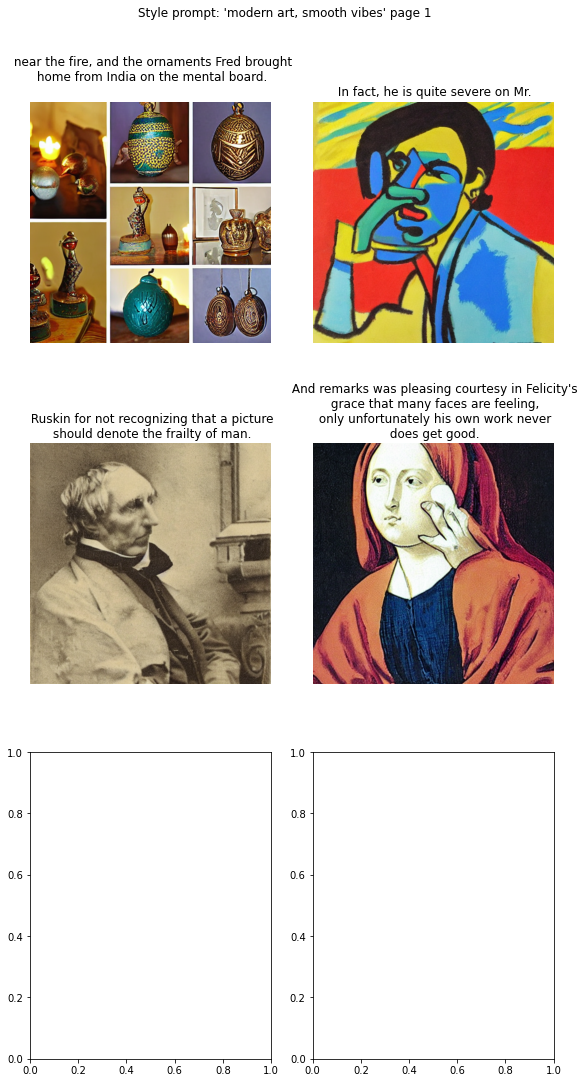

In [68]:
from matplotlib import pyplot as plt
import pathlib

def comic_book_plotter(generated_text, images, style_prompt, image_per_page=6, line_break=40, fig_size=(8,15)):
    name = style_prompt.replace(" ","_").replace(".","_").replace(".","_").strip("_")
    comic_hash = hash("\n".join(generated_text)) + sum(hash(image.tobytes()) for image in images)
    figs = []
    paths = []
    for page_num, id_start in enumerate(range(0,len(generated_text), image_per_page)):
        comic_text = generated_text[id_start:id_start+image_per_page]
        comic_images = images[id_start:id_start+image_per_page]
        if not comic_images:
            break
        fig, axs = plt.subplots(image_per_page//2, 2)
        figs.append(fig)
        fig.set_size_inches(*fig_size)
        
        for image, prompt, ax in zip(comic_images, comic_text,axs.flatten()):
            ax.imshow(image)
            breaks = [0] + [prompt.find(" ", i) for i in range(line_break, len(prompt), line_break)] + [-1]
            formatted_prompt = "\n".join(prompt[i:j] for i, j in zip(breaks[:-1], breaks[1:]))
            ax.set_title(f"{formatted_prompt}")
            ax.axis("off")
        fig.suptitle(f"Style prompt: '{style_prompt}' page {page_num+1}", y=1.0)
        fig.tight_layout()

        pathlib.Path("/storage/comics/").mkdir(exist_ok=True)
        image_path = f"/storage/comics/whisper_to_image_{name}_{comic_hash}-page-{page_num+1}.png"
        paths.append(image_path)
        fig.savefig(image_path, dpi=150)
 
    return figs, paths

fig, image_path = comic_book_plotter(generated_text, images, style_prompt)

In [104]:
import gradio as gr
import librosa

def mic_to_text(rate_and_audio, uploaded_sound):
    if rate_and_audio is None:
        rate_and_audio = uploaded_sound
    source_sample_rate, source_audio= rate_and_audio
    model_sr=16000
    audio = librosa.resample(y=source_audio.astype(float)/np.iinfo(source_audio.dtype).max, orig_sr=source_sample_rate, target_sr=model_sr)
    transcription = ""
    max_model_samples = model_sr * 30
    for i in range(0, len(audio), max_model_samples):
        print(f"  Audio was {len(audio) // sample_rate} seconds long, truncating at 30s")
        transcription += whisper_transcribe(audio[i:(i+1)*max_model_samples], sample_rate)
    return transcription


def text_to_text(prompt):
    return flan_t5(prompt)[0]["generated_text"]



def text_to_image(prompt, n_repeats=4):
    return [pipe(prompt, height=image_height, width=image_width, guidance_scale=7.5).images[0] for _ in range(n_repeats)]


def transcribe_to_comic(rate_and_audio, style_prompt, max_images, transform_sentence_to_prompts, llm_to_sd_prompt, uploaded_sound):
    if rate_and_audio is None:
        rate_and_audio = uploaded_sound
    sample_rate, audio= rate_and_audio
    target_sr=16000
    resample_audio = librosa.resample(y=audio.astype(float)/np.iinfo(audio.dtype).max, orig_sr=sample_rate, target_sr=target_sr)
    transcription, generated_text, images, data = generate_comic(
        resample_audio, style_prompt, sample_rate=target_sr, max_images=max_images, prompt_for_sd=llm_to_sd_prompt, llm_replace=transform_sentence_to_prompts
    )
    figs, paths = comic_book_plotter(generated_text, images, style_prompt, image_per_page=2, line_break=40, fig_size=(8,8))
    return transcription, paths

import soundfile

def to_sample_audio_file(libri_id):
    audio = sample_audio(libri_id)
    file = f"librispeech_validation_{libri_id[0]}-{libri_id[1]}.wav"
    soundfile.write(file, audio, 16000)
    return file


In [105]:
audio_length = 15
audio_examples= [
    to_sample_audio_file((i, i+audio_length)) for i in range(0, len(ds), audio_length)
]

In [106]:

comic_book_app = gr.Interface(
    fn=transcribe_to_comic,
    inputs=[
        gr.Audio(source="microphone", type="numpy"),
        "text",
        gr.Slider(value=10),
        gr.Checkbox(value=False),
        gr.TextArea(value=LLM_prompt),
        gr.Audio(source="upload", type="numpy"),
    ], 
    outputs=["text", gr.Gallery(min_width=800, preview=False)],
    examples=[
        list(e) for e in zip(audio_examples,
        [
            "Aquarel, calm.",
            "Dali, surrealistic, dreamy.",
            "Manga, high resolution, dynamic.",
            "Turner, oil painting.",
        ]* len(audio_examples),
        [None] * len(audio_examples),
        [None] * len(audio_examples),
        [None] * len(audio_examples),
     )
    ]
).queue()

asr_app = gr.Interface(
    fn=mic_to_text,
    inputs=[
        gr.Audio(source="microphone", type="numpy"),
        gr.Audio(source="upload", type="numpy"),
    ], 
    outputs="text",
    examples=[[e, None] for e in audio_examples],
).queue()

text_app = gr.Interface(
    fn=text_to_text,
    inputs="text", 
    outputs="text",
    examples=flan_t5_examples,
).queue()

image_app = gr.Interface(
    fn=text_to_image,
    inputs="text",
    outputs=gr.Gallery(preview=False),
    examples=[
        "A digital illustration of a steampunk library with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors",
        "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
        "A digital Illustration of the Babel tower, 4k, detailed, trending in artstation, fantasy vivid colors",
        "A medieval town with disco lights and a fountain, by Josef Thoma, matte painting trending on artstation HQ, concept art",
        "Editorial Style Photo, (Low Angle|Eye Level), ${THING YOU WANT}, Task Lighting, {MATERIALS}, {STYLE ADJECTIVES}, Symmetric, 4k",
    ],
    
).queue()

In [107]:
from fastapi import FastAPI
import uvicorn
from fastapi.responses import HTMLResponse
app = FastAPI()


@app.get("/", response_class=HTMLResponse)
def read_main():
    return """<!DOCTYPE html>
<html>
<head>
<title>Welcome to the MLOops demo</title>
</head>
<body>

<h1>Welcome to the MLOops demo!</h1>

<p>
This is a collection of Gradio apps demonstrating:

<ul>
<li><a href="/voice">Voice transcription with whisper</a></li>
<li><a href="/text">Text to text generation with T5-large</a></li>
<li><a href="/image">Text to image Stable diffusion</a></li>
</ul>

And all those models are assembled into...
<ul>
<li><a href="/comic">A very bad comic book generator</a></li>
</ul>

</p>
</body>
</html>"""


app = gr.mount_gradio_app(app, comic_book_app, path="/comic")
app = gr.mount_gradio_app(app, text_app, path="/text")
app = gr.mount_gradio_app(app, image_app, path="/image")
app = gr.mount_gradio_app(app, asr_app, path="/voice")


In [ ]:
%env APP_PORT=7865
import nest_asyncio
nest_asyncio.apply()
# Needed for coroutine's in Notebooks
import asyncio
loop = asyncio.get_event_loop()
print("got event loop")

running_app = loop.run_until_complete(
    uvicorn.run(app, host="0.0.0.0", port=int(os.getenv('APP_PORT', 7860)))
)


env: APP_PORT=7865
got event loop


INFO:     Started server process [65]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:7865 (Press CTRL+C to quit)


INFO:     127.0.0.1:58262 - "POST /run/predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:58262 - "GET /file%3D/tmp/gradio/aab7ca3b60c1f940a72dc254dbed5f3c0d80040c/librispeech_validation_0-15.wav HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 58276) - "WebSocket /queue/join" [accepted]
INFO:     connection open


Transcribing audio
  Audio was 145 seconds long, processing part: 1.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 2.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 3.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 4.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 5.0 in chunks of 30s
Continuing story
Transformming Stable diffusion prompts
generating images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[' Mr. ', ' Quilter is the apostle of the middle classes, and we are glad to welcome his gospel. ', ' Nor is Mr. ', " Quilter's manner less interesting than his matter. ", ' He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind. ', " He has grave doubts whether Sir Frederick Layton's work is really Greek after all, and can discover in it but little of rocky Ithaca. ", " Linell's pictures are a sort of up-guards and atom paintings, and Mason's exquisite idles are as national as a jingo poem. ", ' Mr. ', " Birkett Foster's landscapes smile at one much in the same way that Mr. ", ' Carker used to flash his teeth. ', ' And Mr. ', ' John Collier gives his sitter a cheerful slap in the back, before he says like a shampooer in a Turkish Bath. ', ' Next man, it is obviously unnecessary for us to point out how luminous these criticisms are, how delicate an expression. ', ' On

INFO:     connection closed


INFO:     127.0.0.1:58280 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:58454 - "GET /file%3D/tmp/gradio/58eddd9a25146c059310c40f58ef2f025592a631/whisper_to_image_Aquarel_calm_1119362751185231117-page-1.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58458 - "GET /file%3D/tmp/gradio/24dd28df57ffcb9aa102ca555c284acf76ef2ef9/whisper_to_image_Aquarel_calm_1119362751185231117-page-3.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58456 - "GET /file%3D/tmp/gradio/f06da251bddf2d6d9ddb8329ecaf4eb4eeb651e7/whisper_to_image_Aquarel_calm_1119362751185231117-page-2.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58460 - "GET /file%3D/tmp/gradio/6e25317845a5b3965b4b37c2752d54a78a7318f3/whisper_to_image_Aquarel_calm_1119362751185231117-page-5.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58462 - "GET /file%3D/tmp/gradio/d19ad2d2211fc8a9bc814571c9812a96770714c6/whisper_to_image_Aquarel_calm_1119362751185231117-page-4.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58522 - "POST /run/predict HTTP/1.1" 200 OK
INFO:     127.0.0.

INFO:     ('127.0.0.1', 58572) - "WebSocket /queue/join" [accepted]
INFO:     connection open


Transcribing audio
  Audio was 89 seconds long, processing part: 1.0 in chunks of 30s
  Audio was 89 seconds long, processing part: 2.0 in chunks of 30s
  Audio was 89 seconds long, processing part: 3.0 in chunks of 30s
Continuing story
Transformming Stable diffusion prompts
generating images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[' The middle forest is in the Great Doned Cavern, the largest and all-ard dominions, replied Calico. ', ' Calico hesitated. ', ' However, if we look sharp, we may be able to discover one of these secret ways. ', " Oh no, I'm quite sure he didn't. ", " That's funny, remarked Betsy thoughtfully. ", " I don't believe Anne knew any magic, or she'd have worked it before. ", ' I do not know, confessed Shaggy. ', ' True, agreed Calico. ', ' Calico went to the big gong and pounded on it just as Rogadou used to do, but no one answered the summons. ', " Having returned to the Royal Cavern, Calico first pounded the gong and then sat in the throne, wearing Rogadou's discarded ruby crown and holding in his hand to scepter which Rogadou had so often thrown at his head. ", ' A man said to the universe, Sir, I exist. ', " It covered Breon's body, trickling into the tight-lowing cloth that was the only germany war. ", ' The cut on his chest is still dripping blood. ', ' The ache of his overstrained ey

INFO:     connection closed


INFO:     127.0.0.1:58574 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:58748 - "GET /file%3D/tmp/gradio/5516dad1e89ac5d7931ce721db55ac62c14665ea/whisper_to_image_Manga_high_resolution_dynamic_6061129558381962029-page-1.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58750 - "GET /file%3D/tmp/gradio/344cf8fa5c9eef0ba9b467bfa035296b735dca9b/whisper_to_image_Manga_high_resolution_dynamic_6061129558381962029-page-2.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58754 - "GET /file%3D/tmp/gradio/da5f678aebccd6c40ff35e4bb6da9178328d4c51/whisper_to_image_Manga_high_resolution_dynamic_6061129558381962029-page-4.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58752 - "GET /file%3D/tmp/gradio/f7b6d59320329dc3985beea9825e907a5fe93d88/whisper_to_image_Manga_high_resolution_dynamic_6061129558381962029-page-3.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:58756 - "GET /file%3D/tmp/gradio/0a61ceaa99991f90fbfa46b5836902a7b24af730/whisper_to_image_Manga_high_resolution_dynamic_6061129558381962029-page-5.png HTTP/1.1" 200 

INFO:     ('127.0.0.1', 60182) - "WebSocket /queue/join" [accepted]
INFO:     connection open


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:     127.0.0.1:60184 - "POST /api/predict HTTP/1.1" 200 OK


INFO:     connection closed


INFO:     127.0.0.1:60184 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:60252 - "GET /file%3D/tmp/gradio/c80d2845f4bd4ff7124311db706e6b248949c714/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:60254 - "GET /file%3D/tmp/gradio/c35badcf3fe998c246ff4ff27c37c3661951ce51/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:60258 - "GET /file%3D/tmp/gradio/2809bb36eabb4726f8cb8fe3dabc2598dabf7a47/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:60256 - "GET /file%3D/tmp/gradio/27f1ae86188667be5a3ed9eb62e99cd818ece6e4/image.png HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 60410) - "WebSocket /queue/join" [accepted]
INFO:     connection open


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:     127.0.0.1:60412 - "POST /api/predict HTTP/1.1" 200 OK


INFO:     connection closed


INFO:     127.0.0.1:60412 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:60480 - "GET /file%3D/tmp/gradio/afb235dfbec8d99592e6de14eecd8b8e7cc19c6d/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:60482 - "GET /file%3D/tmp/gradio/8b812c8f2fbb24924d2811a85af2b2a70c2451a1/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:60484 - "GET /file%3D/tmp/gradio/84498e6c117535d956b87721b04019577c88ddf5/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:60486 - "GET /file%3D/tmp/gradio/c7ea004a20d552e0591ae385d156b8fe2f017cf1/image.png HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 33042) - "WebSocket /queue/join" [accepted]
INFO:     connection open


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:     127.0.0.1:33046 - "POST /api/predict HTTP/1.1" 200 OK


INFO:     connection closed


INFO:     127.0.0.1:33046 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:33108 - "GET /file%3D/tmp/gradio/2c69f92c8d7b91fd60b8d6570126a97f12b9a3cf/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33110 - "GET /file%3D/tmp/gradio/57f5eb16e0b867d7a887360d6d14e315f55b3cc9/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33106 - "GET /file%3D/tmp/gradio/6063af9743da79f809d0ad181df042ce0ab48645/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33112 - "GET /file%3D/tmp/gradio/845b72276ebf125b7e657c0ef5d54c48997df22f/image.png HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 33172) - "WebSocket /queue/join" [accepted]
INFO:     connection open


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:     127.0.0.1:33174 - "POST /api/predict HTTP/1.1" 200 OK


INFO:     connection closed


INFO:     127.0.0.1:33174 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:33244 - "GET /file%3D/tmp/gradio/546c9bcf8add3d45f126468e082155f3a57ec925/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33242 - "GET /file%3D/tmp/gradio/23b37dbc40c2bb45fab05c1df2277726d1714616/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33246 - "GET /file%3D/tmp/gradio/a983eabd663aa98125d572963d83cf4c53514901/image.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33248 - "GET /file%3D/tmp/gradio/3530c758ba851be51256b7e05dacc8ebbe0cb921/image.png HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 33364) - "WebSocket /queue/join" [accepted]
INFO:     connection open


Transcribing audio
  Audio was 89 seconds long, processing part: 1.0 in chunks of 30s
  Audio was 89 seconds long, processing part: 2.0 in chunks of 30s
  Audio was 89 seconds long, processing part: 3.0 in chunks of 30s
Continuing story
Transformming Stable diffusion prompts
generating images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

['Calico, the middle forest, is in the Great Doned Cavern.', 'Calico shook his head.', 'a man is looking at a map and a man is looking at a map.', "I'm sure he didn't.", 'Betsy was laughing.', 'Anne is a magician.', 'Shaggy is a man who is not a woman.', 'Calico was right.', 'Calico went to the big gong and pounded on it just as Rogadou used to do, but no one answered the summons.', 'he sat in the throne, wearing the ruby crown and holding in his hand the scepter which Rogadou had so often thrown at his head.', 'a man said to the universe, i exist.', "Breon's body, trickling into the tight-lowing cloth that was the only germany war.", 'The man is bleeding from his chest.', 'he shook his head.', 'a man is slashed in the chest with a sharp object.', 'A man is waiting for his train.', '.', 'Breon was thrown from the window.', 'Breon was thrown from the window.', 'Breon was thrown from the window.']
INFO:     127.0.0.1:33366 - "POST /api/predict HTTP/1.1" 200 OK


INFO:     connection closed


INFO:     127.0.0.1:33366 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:33470 - "GET /file%3D/tmp/gradio/dc920c47e1dfb67e4d4faa0510123a04dec1bdf7/whisper_to_image_Manga_high_resolution_dynamic_-10276555084164224349-page-1.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33472 - "GET /file%3D/tmp/gradio/c2ac620a98e1937498b0fed074d80f3b5071ebcb/whisper_to_image_Manga_high_resolution_dynamic_-10276555084164224349-page-2.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:33954 - "POST /run/predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:33954 - "GET /file%3D/tmp/gradio/aab7ca3b60c1f940a72dc254dbed5f3c0d80040c/librispeech_validation_0-15.wav HTTP/1.1" 200 OK
INFO:     127.0.0.1:33996 - "POST /run/predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:33996 - "GET /file%3D/tmp/gradio/5c5041b1254a712d27a491a343cf0c896cfcf8cd/librispeech_validation_30-45.wav HTTP/1.1" 200 OK
INFO:     127.0.0.1:34006 - "POST /run/predict HTTP/1.1" 200 OK


INFO:     ('127.0.0.1', 34014) - "WebSocket /queue/join" [accepted]
INFO:     connection open


Transcribing audio
  Audio was 145 seconds long, processing part: 1.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 2.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 3.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 4.0 in chunks of 30s
  Audio was 145 seconds long, processing part: 5.0 in chunks of 30s
Continuing story
Transformming Stable diffusion prompts
generating images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

['Mr.', 'quilter is the apostle of the middle classes, and we are glad to welcome his gospel.', 'Mr.', "Quilter's manner was less interesting than his matter.", 'he tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind.', "he has grave doubts whether sir frederick layton's work is really greek after all, and can discover in it but little of rocky ithaca.", "Linell's pictures are a sort of up-guards and atom paintings, and Mason's exquisite idles are as national as a jingo poem.", 'Mr.', "Birkett Foster's words smile at one.", 'a man with a snout, a snout, a snout', 'Avery, a man who is a teacher, is a teacher.', 'john collier gives his sitter a cheerful slap in the back, before he says like a shampooer in a Turkish Bath.', 'it is obvious unnecessary for us to point out how luminous these criticisms are, how delicate an expression.', 'smith is a good teacher.', 'lucidity

INFO:     connection closed


INFO:     127.0.0.1:34018 - "POST /reset HTTP/1.1" 200 OK
INFO:     127.0.0.1:34162 - "GET /file%3D/tmp/gradio/9b32aaee36abb3d0060ba8e97e13ebedd0775610/whisper_to_image_Aquarel_calm_-4608898308720304609-page-1.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:34164 - "GET /file%3D/tmp/gradio/c78eeb96389d22af77a1312369c238a3e6d25c25/whisper_to_image_Aquarel_calm_-4608898308720304609-page-2.png HTTP/1.1" 200 OK
